In [1]:
"""
reference:
Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler:
Adaptively setting path lengths in Hamiltonian Monte Carlo.
Journal of Machine Learning Research, 15(1), 1593-1623.
"""

'\nreference:\nHoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler:\nAdaptively setting path lengths in Hamiltonian Monte Carlo.\nJournal of Machine Learning Research, 15(1), 1593-1623.\n'

In [ ]:
"""
This notebook implements and checks scale-invariant priors for the covariance matrix 
in a multivariate normal model using CmdStanPy.

The structure is as follows:
- Install and import required packages
- A small sanity-check example
- Jeffreys prior examples for k = 2 and k = 3 (2 rows)
- Right-invariant prior example for k = 2 (1 row)
- scale-invariant prior example for k = 2 (1 row)
"""

In [2]:
pip install cmdstanpy


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /Users/yaowenting/.cmdstan
Installing CmdStan version: 2.38.0


In [3]:
import os
import tempfile
import numpy as np
from cmdstanpy import CmdStanModel
# from cmdstanpy import install_cmdstan  # run once if needed

# ---------- 1. Stan model code ----------
stan_code = r"""
data {
  int<lower=0> N;                 // number of observations
  array[N] vector[2] y;           // each y[n] is 2D
}
parameters {
  vector[2] mu;                   // 2D mean vector
  cov_matrix[2] Sigma;            // 2x2 covariance matrix
}
model {
  // ---- Priors ----
  mu ~ normal(0, 10);             // mu_j ~ N(0, 10)

  {
    real nu = 4;                  // degrees of freedom (>= 2)
    matrix[2,2] S = diag_matrix(rep_vector(1.0, 2));  // scale matrix (I_2)
    Sigma ~ wishart(nu, S);       // Sigma ~ Wishart_2(nu, S)
  }

  // ---- Likelihood ----
  y ~ multi_normal(mu, Sigma);    // y_n | mu, Sigma ~ N_2(mu, Sigma)
}
"""

# ---------- 2. Write Stan model to a temporary file ----------
tmpdir = tempfile.mkdtemp()
stan_file = os.path.join(tmpdir, "mvn_wishart_2d.stan")
with open(stan_file, "w") as f:
    f.write(stan_code)

# ---------- 3. Simulate some fake 2D data ----------
np.random.seed(123)
true_mu = np.array([1.0, -2.0])

# true covariance matrix (must be SPD)
true_Sigma = np.array([[1.0, 0.5],
                       [0.5, 2.0]])

N = 100
y = np.random.multivariate_normal(true_mu, true_Sigma, size=N)  # shape (N, 2)

stan_data = {
    "N": N,
    "y": y.tolist()  # Stan expects array[N] vector[2] y
}

# ---------- 4. Compile the Stan model ----------
model = CmdStanModel(stan_file=stan_file)

# ---------- 5. Run NUTS sampling ----------
fit = model.sample(
    data=stan_data,
    seed=42,
    chains=4,
    parallel_chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
)

# ---------- 6. Inspect results ----------
print(fit)
summary = fit.summary()
print(summary)

# Posterior draws
posterior_mu = fit.stan_variable("mu")        # shape: (iters*chains, 2)
posterior_Sigma = fit.stan_variable("Sigma")  # shape: (iters*chains, 2, 2)

print("Posterior mean of mu:")
print(posterior_mu.mean(axis=0))

print("Posterior mean of Sigma:")
print(posterior_Sigma.mean(axis=0))


15:55:48 - cmdstanpy - INFO - compiling stan file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpbkxgf3xu/mvn_wishart_2d.stan to exe file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpbkxgf3xu/mvn_wishart_2d
15:56:04 - cmdstanpy - INFO - compiled model executable: /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpbkxgf3xu/mvn_wishart_2d
15:56:05 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:56:06 - cmdstanpy - INFO - CmdStan done processing.
15:56:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is nan. (in 'mvn_wishart_2d.stan', line 17, column 4 to column 27)
	Exception: wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is nan. (in 'mvn_wishart_2d.stan', line 17, column 4 to column 27)
	Exception: wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'mvn_wishart_2d.stan', line 17, column 4 to column 27)
	Exception: wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'mvn_wishart_2d.stan', line 17, column 4 to column 27)
Exception: wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'mvn_wishart_2d.stan', line 17, column 4 to colu


CmdStanMCMC: model=mvn_wishart_2d chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_1.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_2.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_3.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_4.csv
 output_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_0-stdout.txt
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wishart_2d-20260114155605_1-stdout.txt
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_wishart_2d76067zx5/mvn_wisha

15:56:06 - cmdstanpy - INFO - compiling stan file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmp7snq34zt/mvn_jeffreys_cov.stan to exe file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmp7snq34zt/mvn_jeffreys_cov
15:56:23 - cmdstanpy - INFO - compiled model executable: /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmp7snq34zt/mvn_jeffreys_cov
15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 5:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance 


CmdStanMCMC: model=mvn_jeffreys_cov chains=5['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_1.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_2.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_3.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_4.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_5.csv
 output_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_cov566v9a8v/mvn_jeffreys_cov-20260114155624_0-stdout.txt
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_

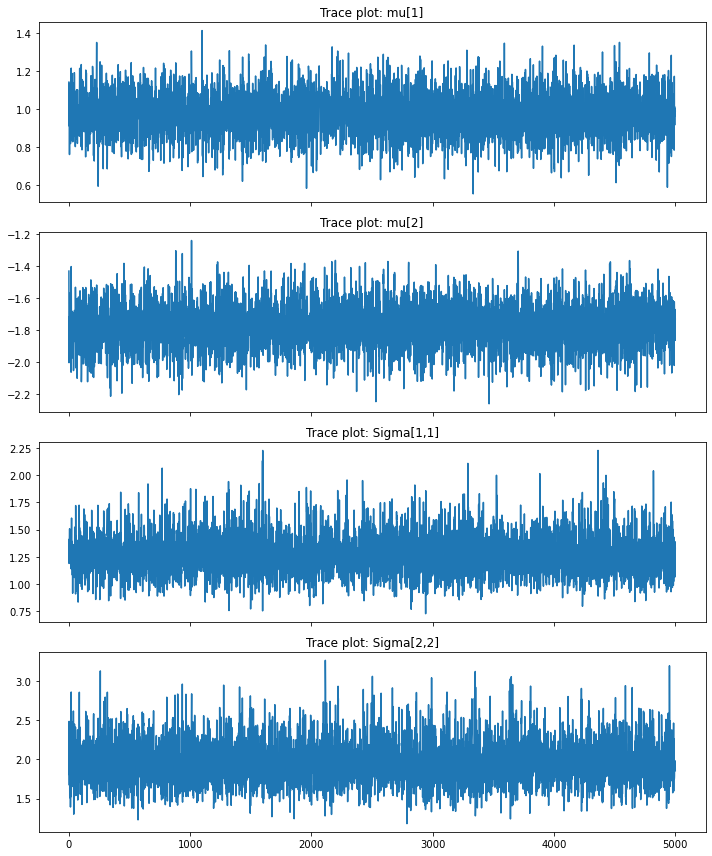

In [4]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
# from cmdstanpy import install_cmdstan  # run once if not installed

# ---------- 1. Stan model code with Jeffreys prior ----------
stan_code = r"""
data {
  int<lower=0> N;               // number of observations
  int<lower=1> K;               // dimension
  array[N] vector[K] y;         // y[n] is K-dimensional
}
parameters {
  vector[K] mu;                 // mean vector
  cov_matrix[K] Sigma;          // K x K covariance matrix
}
model {
  // Prior on mu:
  mu ~ normal(0, 10);

  // Jeffreys prior on Sigma: pi(Sigma) ∝ |Sigma|^{-(K+1)/2}
  target += -0.5 * (K + 1) * log_determinant(Sigma);

  // Likelihood:
  y ~ multi_normal(mu, Sigma);
}
"""

# ---------- 2. Write Stan model to a temporary file ----------
tmpdir = tempfile.mkdtemp()
stan_file = os.path.join(tmpdir, "mvn_jeffreys_cov.stan")
with open(stan_file, "w") as f:
    f.write(stan_code)

# ---------- 3. Simulate some fake K-dimensional data ----------
np.random.seed(123)
K = 2
true_mu = np.array([1.0, -2.0])

true_Sigma = np.array([[1.0, 0.5],
                       [0.5, 2.0]])  # SPD covariance

N = 100
y = np.random.multivariate_normal(true_mu, true_Sigma, size=N)

stan_data = {
    "N": N,
    "K": K,
    "y": y.tolist()  # array[N] vector[K] in Stan
}


# ---------- 4. Compile Stan model ----------
model = CmdStanModel(stan_file=stan_file)

# ---------- 5. Run NUTS sampling ----------
fit = model.sample(
    data=stan_data,
    seed=42,
    chains=5,
    parallel_chains=5,
    iter_warmup=1000,
    iter_sampling=1000,
)

# ---------- 6. Inspect results ----------
print(fit)
summary = fit.summary()
print(summary)

posterior_mu = fit.stan_variable("mu")        # shape: (S, K)
posterior_Sigma = fit.stan_variable("Sigma")  # shape: (S, K, K)

print("Posterior mean of mu:")
print(posterior_mu.mean(axis=0))
mu_sample = np.mean(y, axis=0)
print("Posterior Mean of mu(Theor.):", mu_sample)

print("Posterior mean of Sigma:")
print(posterior_Sigma.mean(axis=0))
Sigma_sample = np.cov(y, rowvar=False)
print("Posterior Mean of Sigma(Theor.):\n", Sigma_sample * (N-1)/(N-K-2))

# Extract diagonal elements
sigma11 = posterior_Sigma[:, 0, 0]
sigma22 = posterior_Sigma[:, 1, 1]

# --- Plot trace plots ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axes[0].plot(posterior_mu[:, 0])
axes[0].set_title("Trace plot: mu[1]")

axes[1].plot(posterior_mu[:, 1])
axes[1].set_title("Trace plot: mu[2]")

axes[2].plot(sigma11)
axes[2].set_title("Trace plot: Sigma[1,1]")

axes[3].plot(sigma22)
axes[3].set_title("Trace plot: Sigma[2,2]")

plt.tight_layout()
plt.show()

15:56:26 - cmdstanpy - INFO - compiling stan file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmphqft0ev_/mvn_jeffreys_cov.stan to exe file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmphqft0ev_/mvn_jeffreys_cov
15:56:45 - cmdstanpy - INFO - compiled model executable: /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmphqft0ev_/mvn_jeffreys_cov
15:56:45 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 5:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:56:51 - cmdstanpy - INFO - CmdStan done processing.
15:56:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'mvn_jeffreys_cov.stan', line 19, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matr


CmdStanMCMC: model=mvn_jeffreys_cov chains=5['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_1.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_2.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_3.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_4.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_5.csv
 output_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_covaqmbm_eo/mvn_jeffreys_cov-20260114155645_0-stdout.txt
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_jeffreys_

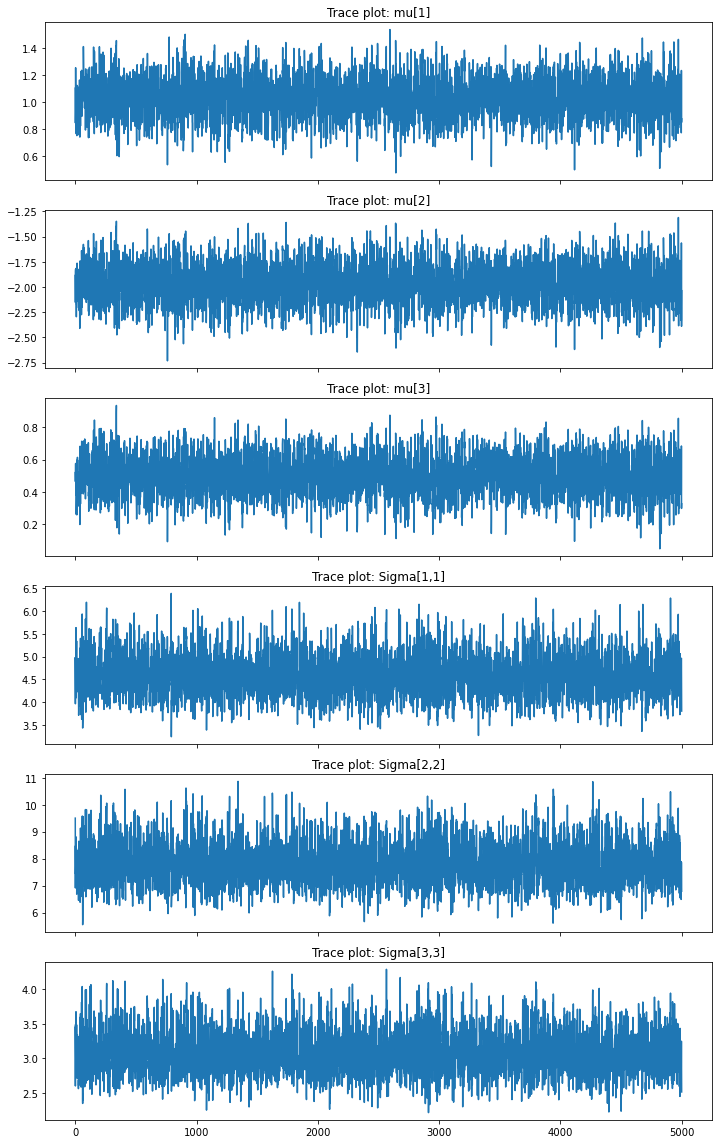

In [5]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
# from cmdstanpy import install_cmdstan  # run once if not installed

# ---------- 1. Stan model code with Jeffreys prior (general K=3) ----------
stan_code = r"""
data {
  int<lower=0> N;               // number of observations
  int<lower=1> K;               // dimension
  array[N] vector[K] y;         // y[n] is K-dimensional
}
parameters {
  vector[K] mu;                 // mean vector
  cov_matrix[K] Sigma;          // K x K covariance matrix
}
model {
  // Prior on mu:
  mu ~ normal(0, 10);

  // Jeffreys prior on Sigma: pi(Sigma) ∝ |Sigma|^{-(K+1)/2}
  target += -0.5 * (K + 1) * log_determinant(Sigma);

  // Likelihood:
  y ~ multi_normal(mu, Sigma);
}
"""

# ---------- 2. Write Stan model to a temporary file ----------
tmpdir = tempfile.mkdtemp()
stan_file = os.path.join(tmpdir, "mvn_jeffreys_cov.stan")
with open(stan_file, "w") as f:
    f.write(stan_code)

# ---------- 3. Simulate some fake K-dimensional data (K = 3) ----------
np.random.seed(123)
K = 3
true_mu = np.array([1.0, -2.0, 0.5])

# Construct an SPD covariance matrix via A A^T
A = np.array([[1.7608551,1.25733541,0.90339709],
 [1.25733541,2.49388355,1.0751151 ],
 [0.90339709,1.0751151,1.28745261]])
true_Sigma = A @ A.T   # 3x3 SPD matrix

N = 200  # number of observations
y = np.random.multivariate_normal(true_mu, true_Sigma, size=N)

stan_data = {
    "N": N,
    "K": K,
    "y": y.tolist()  # array[N] vector[K] in Stan
}

# ---------- 4. Compile Stan model ----------
model = CmdStanModel(stan_file=stan_file)

# ---------- 5. Run NUTS sampling ----------
fit = model.sample(
    data=stan_data,
    seed=42,
    chains=5,
    parallel_chains=5,
    iter_warmup=1000,
    iter_sampling=1000,
)

# ---------- 6. Inspect results ----------
print(fit)
summary = fit.summary()
print(summary)

posterior_mu = fit.stan_variable("mu")        # shape: (S, K)
posterior_Sigma = fit.stan_variable("Sigma")  # shape: (S, K, K)

print("True mu:", true_mu)
print("Posterior mean of mu:", posterior_mu.mean(axis=0))
mu_sample = np.mean(y, axis=0)
print("Posterior Mean of mu(Theor.):", mu_sample)

print("True Sigma:\n", true_Sigma)
print("Posterior mean of Sigma:\n", posterior_Sigma.mean(axis=0))
Sigma_sample = np.cov(y, rowvar=False)
print("Posterior Mean of Sigma(Theor.):\n", Sigma_sample * (N-1)/(N-K-2))

# ---------- 7. Extract diagonal elements of Sigma ----------
sigma11 = posterior_Sigma[:, 0, 0]
sigma22 = posterior_Sigma[:, 1, 1]
sigma33 = posterior_Sigma[:, 2, 2]

# ---------- 8. Trace plots for mu[1:3] and diag(Sigma) ----------
fig, axes = plt.subplots(6, 1, figsize=(10, 16), sharex=True)

axes[0].plot(posterior_mu[:, 0])
axes[0].set_title("Trace plot: mu[1]")

axes[1].plot(posterior_mu[:, 1])
axes[1].set_title("Trace plot: mu[2]")

axes[2].plot(posterior_mu[:, 2])
axes[2].set_title("Trace plot: mu[3]")

axes[3].plot(sigma11)
axes[3].set_title("Trace plot: Sigma[1,1]")

axes[4].plot(sigma22)
axes[4].set_title("Trace plot: Sigma[2,2]")

axes[5].plot(sigma33)
axes[5].set_title("Trace plot: Sigma[3,3]")

plt.tight_layout()
plt.show()

15:56:52 - cmdstanpy - INFO - compiling stan file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpmh28ivgp/mvn_right_invariant_cov.stan to exe file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpmh28ivgp/mvn_right_invariant_cov
15:57:11 - cmdstanpy - INFO - compiled model executable: /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpmh28ivgp/mvn_right_invariant_cov
15:57:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 5:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:57:13 - cmdstanpy - INFO - CmdStan done processing.
15:57:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_right_invariant_cov.stan', line 22, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_right_invariant_cov.stan', line 22, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_right_invariant_cov.stan', line 22, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_right_invariant_cov.stan', line 22, column 2 to column 30)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = n


CmdStanMCMC: model=mvn_right_invariant_cov chains=5['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-20260114155711_1.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-20260114155711_2.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-20260114155711_3.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-20260114155711_4.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-20260114155711_5.csv
 output_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_right_invariant_covazc9c0c0/mvn_right_invariant_cov-202601141557

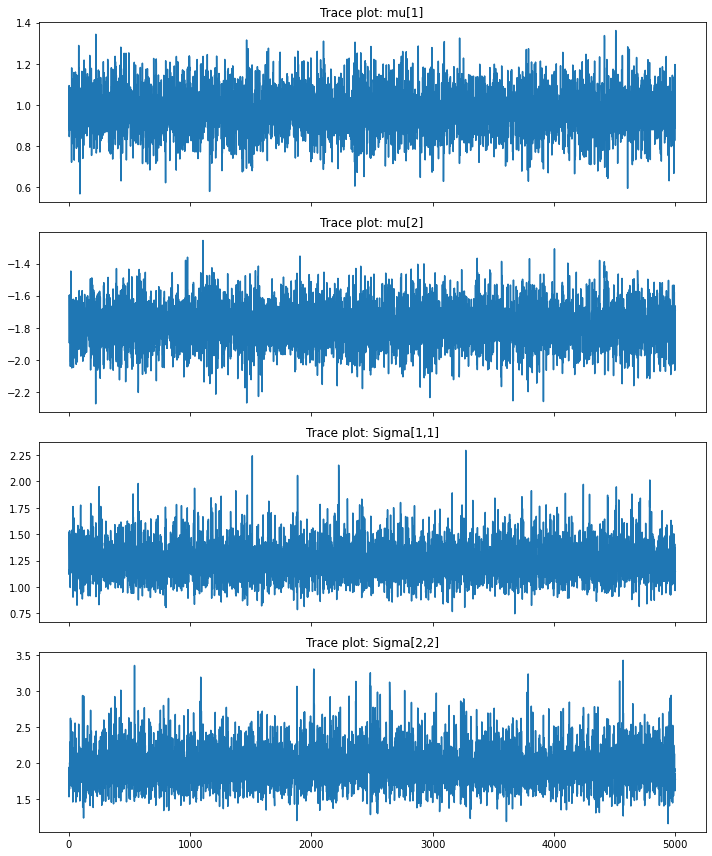

In [6]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
# from cmdstanpy import install_cmdstan  # run once if not installed

# ---------- 1. Stan model code with RIGHT-INVARIANT prior ----------
stan_code = r"""
data {
  int<lower=0> N;               // number of observations
  int<lower=1> K;               // dimension
  array[N] vector[K] y;         // y[n] is K-dimensional
}
parameters {
  vector[K] mu;                 // mean vector
  cov_matrix[K] Sigma;          // K x K covariance matrix
}
model {
  // Prior on mu:
  mu ~ normal(0, 10);

  // Right-invariant prior on Sigma:
  // pi_R(Sigma) ∝ 1 / prod_{l=1}^K |Sigma_l|
  for (l in 1:K) {
    target += -log_determinant(Sigma[1:l, 1:l]);
  }

  // Likelihood:
  y ~ multi_normal(mu, Sigma);
}
"""

# ---------- 2. Write Stan model to a temporary file ----------
tmpdir = tempfile.mkdtemp()
stan_file = os.path.join(tmpdir, "mvn_right_invariant_cov.stan")
with open(stan_file, "w") as f:
    f.write(stan_code)

# ---------- 3. Simulate some fake K-dimensional data ----------
np.random.seed(123)
K = 2
true_mu = np.array([1.0, -2.0])

true_Sigma = np.array([[1.0, 0.5],
                       [0.5, 2.0]])  # SPD covariance

N = 100
y = np.random.multivariate_normal(true_mu, true_Sigma, size=N)

stan_data = {
    "N": N,
    "K": K,
    "y": y.tolist()  # array[N] vector[K] in Stan
}

# ---------- 4. Compile Stan model ----------
model = CmdStanModel(stan_file=stan_file)

# ---------- 5. Run NUTS sampling ----------
fit = model.sample(
    data=stan_data,
    seed=42,
    chains=5,
    parallel_chains=5,
    iter_warmup=1000,
    iter_sampling=1000,
)

# ---------- 6. Inspect results ----------
print(fit)
summary = fit.summary()
print(summary)

posterior_mu = fit.stan_variable("mu")        # shape: (S, K)
posterior_Sigma = fit.stan_variable("Sigma")  # shape: (S, K, K)

print("Posterior mean of mu:")
print(posterior_mu.mean(axis=0))

print("Posterior mean of Sigma:")
print(posterior_Sigma.mean(axis=0))

# Extract diagonal elements
sigma11 = posterior_Sigma[:, 0, 0]
sigma22 = posterior_Sigma[:, 1, 1]

# --- Plot trace plots ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axes[0].plot(posterior_mu[:, 0])
axes[0].set_title("Trace plot: mu[1]")

axes[1].plot(posterior_mu[:, 1])
axes[1].set_title("Trace plot: mu[2]")

axes[2].plot(sigma11)
axes[2].set_title("Trace plot: Sigma[1,1]")

axes[3].plot(sigma22)
axes[3].set_title("Trace plot: Sigma[2,2]")

plt.tight_layout()
plt.show()


16:03:52 - cmdstanpy - INFO - compiling stan file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpv48eux7c/mvn_rscale_invariant_cov.stan to exe file /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpv48eux7c/mvn_rscale_invariant_cov
16:04:09 - cmdstanpy - INFO - compiled model executable: /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpv48eux7c/mvn_rscale_invariant_cov
16:04:09 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
16:04:09 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=mvn_rscale_invariant_cov.stan --o=/private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpv48eux7c/mvn_rscale_invariant_cov.hpp /private/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpv48eux7c/mvn_rscale_invariant_cov.stan
Warning in 'mvn_rscale_invariant_cov.stan', line 33, column 16: Found int
    division:
      tmp / 2
    Values will be rounded towards zero. If rounding is not desired you can
    writ

chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 5:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

16:04:11 - cmdstanpy - INFO - CmdStan done processing.
16:04:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_rscale_invariant_cov.stan', line 75, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in 'mvn_rscale_invariant_cov.stan', line 75, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_rscale_invariant_cov.stan', line 75, column 2 to column 30)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in 'mvn_rscale_invariant_cov.stan', line 75, column 2 to column 30)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2]


CmdStanMCMC: model=mvn_rscale_invariant_cov chains=5['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov-20260114160410_1.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov-20260114160410_2.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov-20260114160410_3.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov-20260114160410_4.csv
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov-20260114160410_5.csv
 output_files:
	/var/folders/gm/p3_0_8856xjdp5ghnksvb5xc0000gn/T/tmpjpzm01dz/mvn_rscale_invariant_covzkvbvblf/mvn_rscale_invariant_cov

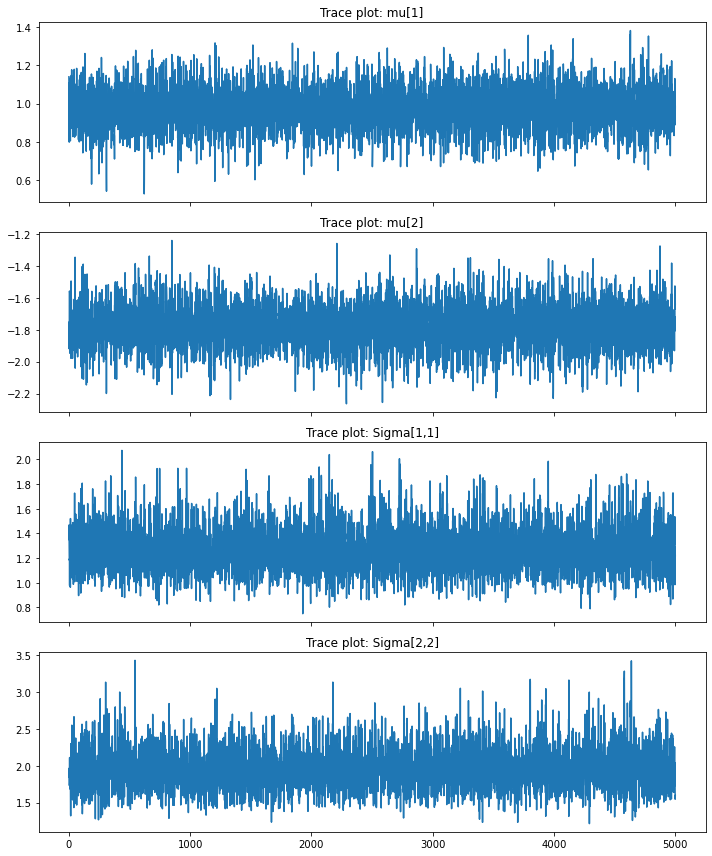

In [9]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
# from cmdstanpy import install_cmdstan  # run once if not installed

# ---------- 1. Stan model code with scale-invarient RIGHT prior ----------
stan_code = r"""
functions {
  // ---------------------------------------------------------------
  // General-k scale-right prior:
  // log π(Σ) = - Σ_{i=1..K} (1/choose(k,i)) Σ_{I ⊂ {1..K}, |I| = i} log |Σ_I|
  // Enumerates all subsets using bitmasks.
  // ---------------------------------------------------------------
  real scale_right_prior_log(matrix Sigma, int K) {
    real log_val = 0;

    // total subsets = 2^K
    int max_mask = 1;
    for (i in 1:K)
      max_mask *= 2;  // ∴ max_mask = 2^K

    // subset sizes i = 1 .. K
    for (i in 1:K) {
      real sum_log = 0;
      int m_count = 0;

      // loop over all nonempty subsets via bitmask
      for (mask in 1:(max_mask - 1)) {
        array[K] int idx;
        int idx_len = 0;
        int tmp = mask;

        // decode subset indices from bitmask
        for (j in 1:K) {
          if (tmp % 2 == 1) {
            idx_len += 1;
            idx[idx_len] = j;
          }
          tmp = tmp / 2;
        }

        // skip subsets whose size ≠ i
        if (idx_len == i) {
          real log_det_sub =
            log_determinant(Sigma[idx[1:i], idx[1:i]]);

          // add -log(det)
          sum_log += -log_det_sub;
          m_count += 1;
        }
      }

      // add average log(1/|Σ_I|)
      log_val += sum_log / m_count;

    }

    return log_val;
  }
}

data {
  int<lower=0> N;               // number of observations
  int<lower=1> K;               // dimension
  array[N] vector[K] y;         // data points
}

parameters {
  vector[K] mu;                 // mean vector
  cov_matrix[K] Sigma;          // k×k SPD covariance matrix
}

model {
  // prior on mu
  mu ~ normal(0, 10);

  // your general-k prior
  target += scale_right_prior_log(Sigma, K);

  // likelihood
  y ~ multi_normal(mu, Sigma);
}

"""

# ---------- 2. Write Stan model to a temporary file ----------
tmpdir = tempfile.mkdtemp()
stan_file = os.path.join(tmpdir, "mvn_rscale_invariant_cov.stan")
with open(stan_file, "w") as f:
    f.write(stan_code)

# ---------- 3. Simulate some fake K-dimensional data ----------
np.random.seed(123)
K = 2
true_mu = np.array([1.0, -2.0])

true_Sigma = np.array([[1.0, 0.5],
                       [0.5, 2.0]])  # SPD covariance

N = 100
y = np.random.multivariate_normal(true_mu, true_Sigma, size=N)

stan_data = {
    "N": N,
    "K": K,
    "y": y.tolist()  # array[N] vector[K] in Stan
}

# ---------- 4. Compile Stan model ----------
model = CmdStanModel(stan_file=stan_file)

# ---------- 5. Run NUTS sampling ----------
fit = model.sample(
    data=stan_data,
    seed=42,
    chains=5,
    parallel_chains=5,
    iter_warmup=1000,
    iter_sampling=1000,
)

# ---------- 6. Inspect results ----------
print(fit)
summary = fit.summary()
print(summary)

posterior_mu = fit.stan_variable("mu")        # shape: (S, K)
posterior_Sigma = fit.stan_variable("Sigma")  # shape: (S, K, K)

print("Posterior mean of mu:")
print(posterior_mu.mean(axis=0))

print("Posterior mean of Sigma:")
print(posterior_Sigma.mean(axis=0))

# Extract diagonal elements
sigma11 = posterior_Sigma[:, 0, 0]
sigma22 = posterior_Sigma[:, 1, 1]

# --- Plot trace plots ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axes[0].plot(posterior_mu[:, 0])
axes[0].set_title("Trace plot: mu[1]")

axes[1].plot(posterior_mu[:, 1])
axes[1].set_title("Trace plot: mu[2]")

axes[2].plot(sigma11)
axes[2].set_title("Trace plot: Sigma[1,1]")

axes[3].plot(sigma22)
axes[3].set_title("Trace plot: Sigma[2,2]")

plt.tight_layout()
plt.show()
